一、import some package

In [9]:
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils,plot_model
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
import resnet
import os
import pandas as pd
import random

import pylab
import imageio
imageio.plugins.ffmpeg.download()
import skimage

#from skimage import data, exposure
from skimage.transform import resize
#from skimage.io import imread, imshow, imread_collection, concatenate_images
from sklearn.cross_validation import train_test_split



import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain

import scipy
from keras.models import Model, load_model
from keras.layers import Input,BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


二、读取图片进入X,Y

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
0


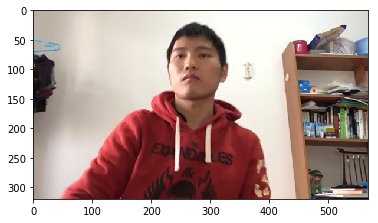

1


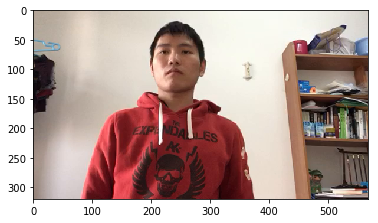

2


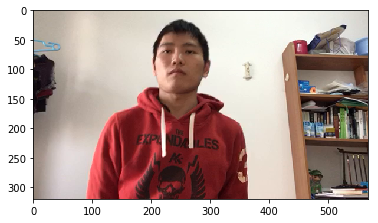

3


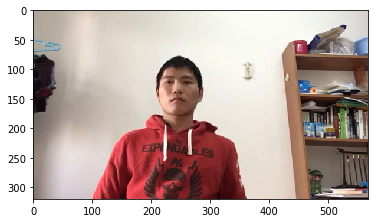

4


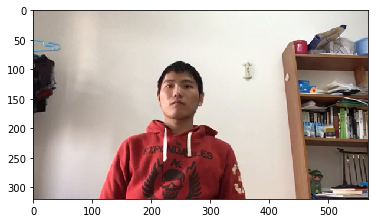

5


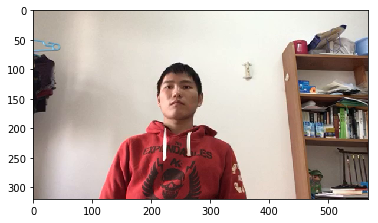

6


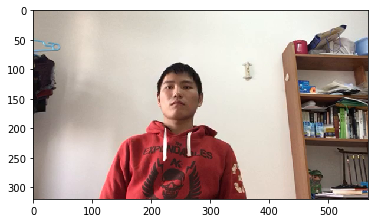

7


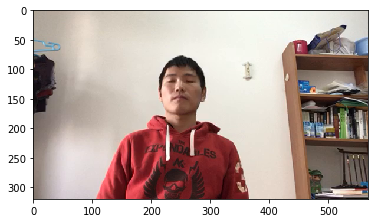

8


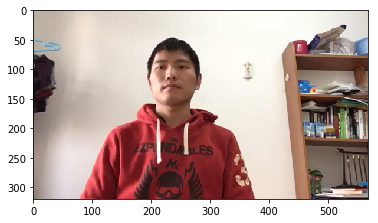

9


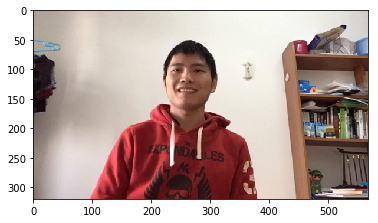

10


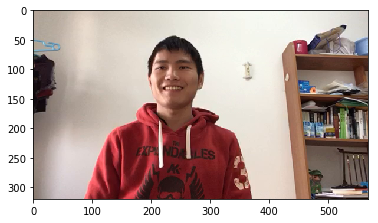

11


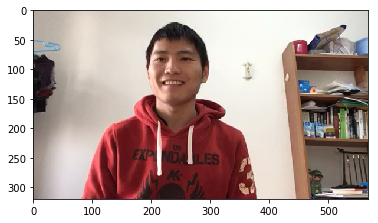

12


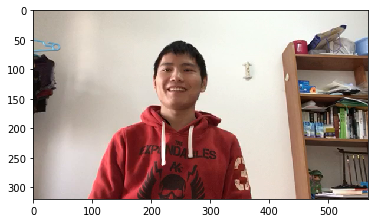

13


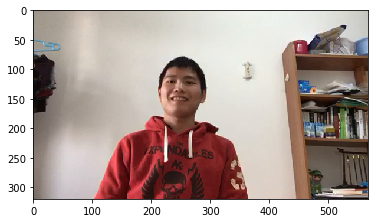

14


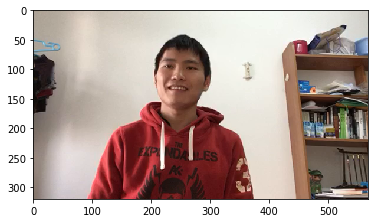

15


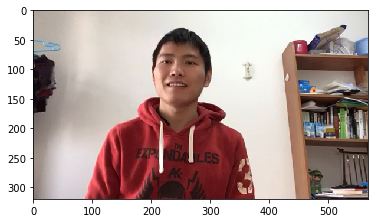

16


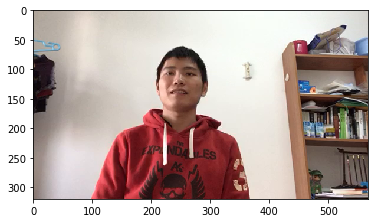

17


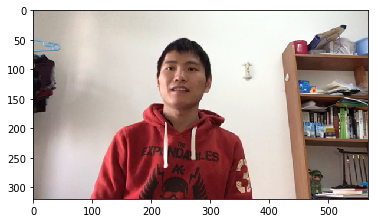

18


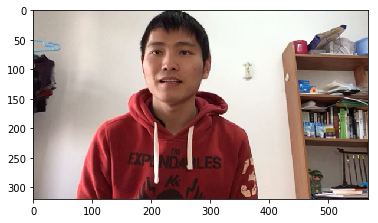

19


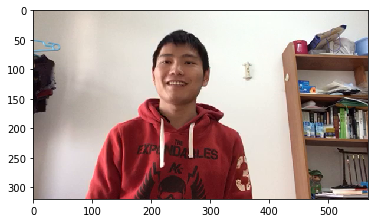

20


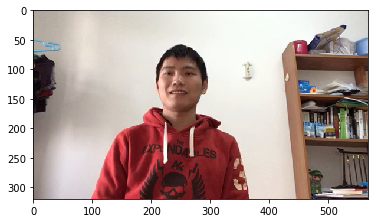

21


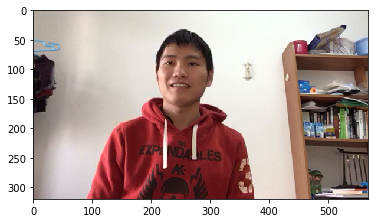

22


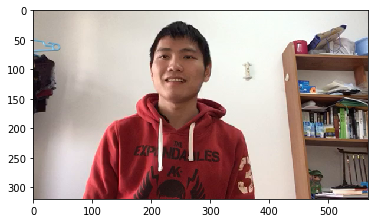

23


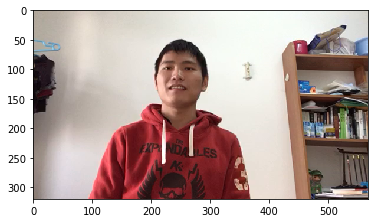

24


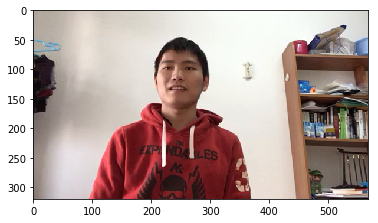

25


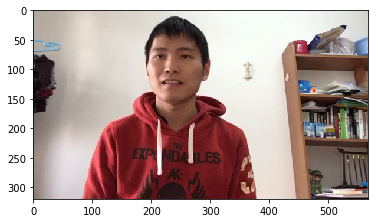

26


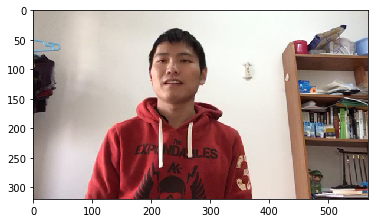

27


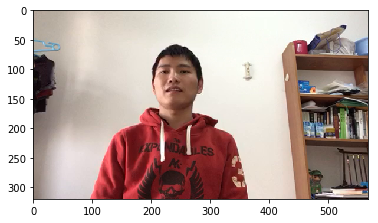

28


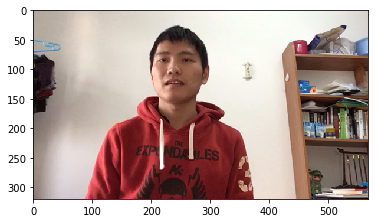

29


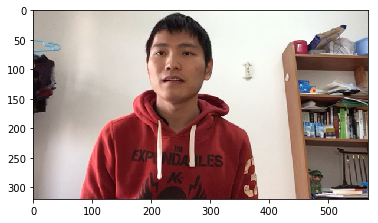

In [11]:
img_rows=320
img_cols=568
img_channels=3
nb_classes=5
m=180

filename = r'C:\Users\wangpeizhi\Desktop\video.mp4'
vid = imageio.get_reader(filename,  'ffmpeg') 
X=np.zeros([m,img_rows,img_cols,img_channels])
Y=np.zeros([m,nb_classes])
indice=0
for im in enumerate(vid):
    if(im[0]%30==0)&(indice<m):
        X[indice,:,:,:]=im[1]
        indice +=1
        print(indice)

In [19]:
for j in range(32):
    Y[j,0]=1
for j in range(32,64):
    Y[j,1]=1
for j in range(64,112):
    Y[j,2]=1
for j in range(112,152):
    Y[j,3]=1
for j in range(152,180):
    Y[j,4]=1

三、网络的一些超参数

In [21]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=7, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.0005, patience=40)
csv_logger = CSVLogger('imagemodel4.0.csv')
checkpointer = ModelCheckpoint('imagemodel4.0.h5', verbose=1, save_best_only=True)
batch_size = 10
nb_epoch = 300
data_augmentation = False

四、预处理，白化

In [22]:
X=X.astype('float32')
mean_X=np.mean(X,axis=0)
X -= mean_X  #白化，X减去所有数据的均值
X /=128 #这样X大概就是在-1~1之间的分布了

五、搭建网络模型，编译

In [23]:
model = resnet.ResnetBuilder.build_resnet_34((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
#plot_model(model, to_file='model V2.0.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 568, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 284, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 284, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 160, 284, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
add_5 (Add)                     (None, 40, 71, 128)  0           add_4[0][0]                      
                                                                 conv2d_12[0][0]                  
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 40, 71, 128)  512         add_5[0][0]                      
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 40, 71, 128)  0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 40, 71, 128)  147584      activation_11[0][0]              
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
activation_21 (Activation)      (None, 20, 36, 256)  0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 20, 36, 256)  590080      activation_21[0][0]              
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 20, 36, 256)  1024        conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 20, 36, 256)  0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 20, 36, 256)  590080      activation_22[0][0]              
__________

batch_normalization_32 (BatchNo (None, 10, 18, 512)  2048        conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 10, 18, 512)  0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 10, 18, 512)  2359808     activation_32[0][0]              
__________________________________________________________________________________________________
add_16 (Add)                    (None, 10, 18, 512)  0           add_15[0][0]                     
                                                                 conv2d_36[0][0]                  
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 10, 18, 512)  2048        add_16[0][0]                     
__________

六、分割X={X_train,X_val}  Y={Y_train,Y_val}

In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print("X_train.shape=",X_train.shape)
print("Y_train.shape=",Y_train.shape)
print("X_val.shape=",X_val.shape)
print("Y_val.shape=",Y_val.shape)

X_train.shape= (144, 320, 568, 3)
Y_train.shape= (144, 5)
X_val.shape= (36, 320, 568, 3)
Y_val.shape= (36, 5)


七、数据增强，训练

In [25]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              verbose=1,
              validation_data=(X_val, Y_val),
              shuffle=True,
              callbacks=[lr_reducer,checkpointer, early_stopper, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=False,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=False,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_val, Y_val),
                        epochs=nb_epoch, verbose=1, max_q_size=100,
                        callbacks=[lr_reducer,checkpointer, early_stopper, csv_logger])


Not using data augmentation.
Train on 144 samples, validate on 36 samples
Epoch 1/300
144/144 [==============================] - ETA: 4:49 - loss: 2.9284 - acc: 0.500 - ETA: 3:39 - loss: 2.6703 - acc: 0.600 - ETA: 3:06 - loss: 2.6094 - acc: 0.533 - ETA: 2:43 - loss: 2.5209 - acc: 0.575 - ETA: 2:24 - loss: 2.4873 - acc: 0.600 - ETA: 2:07 - loss: 2.5040 - acc: 0.600 - ETA: 1:51 - loss: 2.5540 - acc: 0.528 - ETA: 1:35 - loss: 2.5168 - acc: 0.537 - ETA: 1:19 - loss: 2.4819 - acc: 0.555 - ETA: 1:04 - loss: 2.4869 - acc: 0.560 - ETA: 49s - loss: 2.4532 - acc: 0.581 - ETA: 34s - loss: 2.4190 - acc: 0.59 - ETA: 20s - loss: 2.4213 - acc: 0.60 - ETA: 5s - loss: 2.4057 - acc: 0.6143 - 223s 2s/step - loss: 2.4011 - acc: 0.6111 - val_loss: 14.7503 - val_acc: 0.1667

Epoch 00001: val_loss improved from inf to 14.75033, saving model to imagemodel4.0.h5
Epoch 2/300
144/144 [==============================] - ETA: 3:06 - loss: 1.8680 - acc: 1.000 - ETA: 2:52 - loss: 1.8710 - acc: 0.900 - ETA: 2:38 - los

144/144 [==============================] - ETA: 3:04 - loss: 0.8498 - acc: 1.000 - ETA: 2:50 - loss: 0.9760 - acc: 1.000 - ETA: 2:36 - loss: 0.9510 - acc: 1.000 - ETA: 2:23 - loss: 0.9371 - acc: 1.000 - ETA: 2:09 - loss: 0.9390 - acc: 1.000 - ETA: 1:55 - loss: 0.9386 - acc: 1.000 - ETA: 1:42 - loss: 0.9652 - acc: 0.971 - ETA: 1:28 - loss: 0.9553 - acc: 0.975 - ETA: 1:14 - loss: 0.9697 - acc: 0.966 - ETA: 1:00 - loss: 0.9586 - acc: 0.970 - ETA: 47s - loss: 0.9699 - acc: 0.963 - ETA: 33s - loss: 0.9575 - acc: 0.96 - ETA: 19s - loss: 0.9496 - acc: 0.96 - ETA: 5s - loss: 0.9558 - acc: 0.9571 - 215s 1s/step - loss: 0.9542 - acc: 0.9583 - val_loss: 9.6558 - val_acc: 0.3056

Epoch 00011: val_loss did not improve
Epoch 12/300
144/144 [==============================] - ETA: 3:05 - loss: 0.8593 - acc: 1.000 - ETA: 2:52 - loss: 0.8321 - acc: 1.000 - ETA: 2:38 - loss: 0.8544 - acc: 1.000 - ETA: 2:24 - loss: 0.8535 - acc: 1.000 - ETA: 2:10 - loss: 0.8448 - acc: 1.000 - ETA: 1:56 - loss: 0.8570 - ac

144/144 [==============================] - ETA: 3:06 - loss: 0.5784 - acc: 1.000 - ETA: 2:52 - loss: 0.5685 - acc: 1.000 - ETA: 2:38 - loss: 0.5606 - acc: 1.000 - ETA: 2:24 - loss: 0.5621 - acc: 1.000 - ETA: 2:10 - loss: 0.5928 - acc: 0.980 - ETA: 1:56 - loss: 0.5882 - acc: 0.983 - ETA: 1:42 - loss: 0.5939 - acc: 0.985 - ETA: 1:28 - loss: 0.5891 - acc: 0.987 - ETA: 1:14 - loss: 0.5848 - acc: 0.988 - ETA: 1:00 - loss: 0.5823 - acc: 0.990 - ETA: 47s - loss: 0.5784 - acc: 0.990 - ETA: 33s - loss: 0.5799 - acc: 0.99 - ETA: 19s - loss: 0.5830 - acc: 0.99 - ETA: 5s - loss: 0.5886 - acc: 0.9929 - 215s 1s/step - loss: 0.5911 - acc: 0.9931 - val_loss: 2.4261 - val_acc: 0.6111

Epoch 00022: val_loss did not improve
Epoch 23/300
144/144 [==============================] - ETA: 3:04 - loss: 0.5503 - acc: 1.000 - ETA: 2:50 - loss: 0.5944 - acc: 1.000 - ETA: 2:36 - loss: 0.5848 - acc: 1.000 - ETA: 2:23 - loss: 0.5712 - acc: 1.000 - ETA: 2:10 - loss: 0.5917 - acc: 1.000 - ETA: 1:56 - loss: 0.5911 - ac

144/144 [==============================] - ETA: 3:29 - loss: 0.4490 - acc: 1.000 - ETA: 3:13 - loss: 0.4464 - acc: 1.000 - ETA: 2:57 - loss: 0.4485 - acc: 1.000 - ETA: 2:41 - loss: 0.4469 - acc: 1.000 - ETA: 2:25 - loss: 0.4504 - acc: 1.000 - ETA: 2:10 - loss: 0.4511 - acc: 1.000 - ETA: 1:54 - loss: 0.4504 - acc: 1.000 - ETA: 1:39 - loss: 0.4526 - acc: 1.000 - ETA: 1:23 - loss: 0.4540 - acc: 1.000 - ETA: 1:08 - loss: 0.4540 - acc: 1.000 - ETA: 52s - loss: 0.4550 - acc: 1.000 - ETA: 37s - loss: 0.4545 - acc: 1.00 - ETA: 21s - loss: 0.4534 - acc: 1.00 - ETA: 6s - loss: 0.4538 - acc: 1.0000 - 239s 2s/step - loss: 0.4554 - acc: 1.0000 - val_loss: 1.1093 - val_acc: 0.7222

Epoch 00033: val_loss did not improve
Epoch 34/300
144/144 [==============================] - ETA: 3:25 - loss: 0.4504 - acc: 1.000 - ETA: 3:09 - loss: 0.5146 - acc: 0.950 - ETA: 2:54 - loss: 0.4941 - acc: 0.966 - ETA: 2:39 - loss: 0.4815 - acc: 0.975 - ETA: 2:24 - loss: 0.4725 - acc: 0.980 - ETA: 2:09 - loss: 0.4716 - ac

144/144 [==============================] - ETA: 3:02 - loss: 0.4239 - acc: 1.000 - ETA: 2:47 - loss: 0.4244 - acc: 1.000 - ETA: 2:34 - loss: 0.4251 - acc: 1.000 - ETA: 2:20 - loss: 0.4251 - acc: 1.000 - ETA: 2:07 - loss: 0.4240 - acc: 1.000 - ETA: 1:53 - loss: 0.4237 - acc: 1.000 - ETA: 1:40 - loss: 0.4232 - acc: 1.000 - ETA: 1:26 - loss: 0.4234 - acc: 1.000 - ETA: 1:13 - loss: 0.4229 - acc: 1.000 - ETA: 59s - loss: 0.4226 - acc: 1.000 - ETA: 46s - loss: 0.4243 - acc: 1.00 - ETA: 32s - loss: 0.4245 - acc: 1.00 - ETA: 18s - loss: 0.4260 - acc: 1.00 - ETA: 5s - loss: 0.4255 - acc: 1.0000 - 210s 1s/step - loss: 0.4255 - acc: 1.0000 - val_loss: 0.5600 - val_acc: 0.9722

Epoch 00044: val_loss improved from 0.56236 to 0.55996, saving model to imagemodel4.0.h5
Epoch 45/300
144/144 [==============================] - ETA: 3:01 - loss: 0.4186 - acc: 1.000 - ETA: 2:47 - loss: 0.4414 - acc: 1.000 - ETA: 2:34 - loss: 0.4357 - acc: 1.000 - ETA: 2:20 - loss: 0.4321 - acc: 1.000 - ETA: 2:07 - loss: 0.

144/144 [==============================] - ETA: 3:06 - loss: 0.4248 - acc: 1.000 - ETA: 2:50 - loss: 0.4190 - acc: 1.000 - ETA: 2:37 - loss: 0.4170 - acc: 1.000 - ETA: 2:23 - loss: 0.4158 - acc: 1.000 - ETA: 2:08 - loss: 0.4149 - acc: 1.000 - ETA: 1:54 - loss: 0.4186 - acc: 1.000 - ETA: 1:41 - loss: 0.4215 - acc: 1.000 - ETA: 1:27 - loss: 0.4207 - acc: 1.000 - ETA: 1:14 - loss: 0.4201 - acc: 1.000 - ETA: 1:00 - loss: 0.4192 - acc: 1.000 - ETA: 46s - loss: 0.4186 - acc: 1.000 - ETA: 32s - loss: 0.4181 - acc: 1.00 - ETA: 19s - loss: 0.4176 - acc: 1.00 - ETA: 5s - loss: 0.4176 - acc: 1.0000 - 214s 1s/step - loss: 0.4215 - acc: 1.0000 - val_loss: 0.4237 - val_acc: 1.0000

Epoch 00054: val_loss improved from 0.42653 to 0.42373, saving model to imagemodel4.0.h5
Epoch 55/300
144/144 [==============================] - ETA: 3:04 - loss: 0.4110 - acc: 1.000 - ETA: 2:50 - loss: 0.4227 - acc: 1.000 - ETA: 2:36 - loss: 0.4197 - acc: 1.000 - ETA: 2:22 - loss: 0.4180 - acc: 1.000 - ETA: 2:11 - loss: 

KeyboardInterrupt: 

八、测试

In [26]:
for im in enumerate(vid):
    len_video=im[0]+1
print(len_video)

In [37]:
model = load_model('imagemodel4.0.h5')
#del X
#del PRED
#del pred
PRED=np.zeros([len_video,1])
sample=np.zeros([1,img_rows,img_cols,img_channels])
indice=0
for im in enumerate(vid):
    sample[0,:,:,:]=im[1]
    sample -=mean_X
    sample /= 128
    pred=model.predict(sample)
    PRED[indice]=np.argmax(pred)
    print(PRED[indice])
    indice +=1

[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[2.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]
[3.]


[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]
[4.]


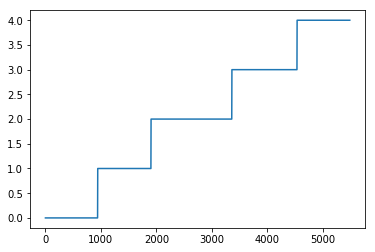

In [39]:
plt.plot(PRED)
plt.show()


In [34]:
print(X[0].shape)

(320, 568, 3)


In [ ]:
plt.plot(pred)

相比如V1.0版本，这里把resnet18改成了resnet34

In [89]:
def mapmaxmin(x):
    MIN=np.min(x)
    MAX=np.max(x)
    return (x-MIN)/(MAX-MIN)